# Enhancing orientations

## We need some modules

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import skimage.filters as flt
import skimage.io as io
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from matplotlib.patches import ConnectionPatch
from scipy.signal import medfilt

## Literature
[Z. Püspöki, M. Storath, D. Sage, M. Unser 2016](https://doi.org/10.1007/978-3-319-28549-8_3)  
[Bigün 2000](link)

[Orientation demonstration](http://bigwww.epfl.ch/demo/ip/demos/orientation/)

## Analysis of orientation in structured images

In [134]:
balls = io.imread('figures/recon5s_0130.tif').astype(float)
hair  = io.imread('figures/hair.jpeg').astype(float).mean(axis=2)
pea   = io.imread('figures/peacock.jpeg').astype(float).mean(axis=2)

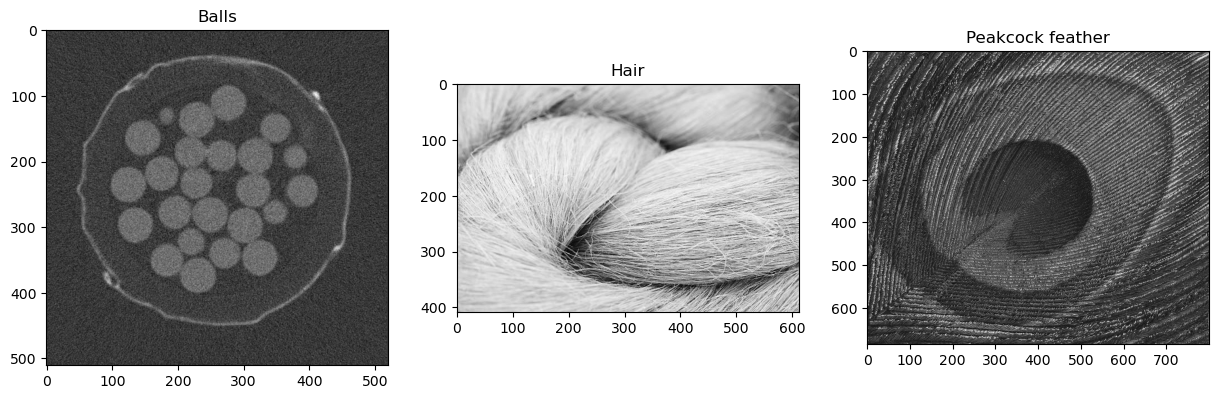

In [135]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(balls,cmap='gray')
ax[0].set_title('Balls')
ax[1].imshow(hair,cmap='gray')
ax[1].set_title('Hair')
ax[2].imshow(pea,cmap='gray')
ax[2].set_title('Peakcock feather');

### Gradients

We just learned that the gradient can isolate edge information in the image. It is also computed along the principal axes of the image. Below, we see the gradient of the three test images. 

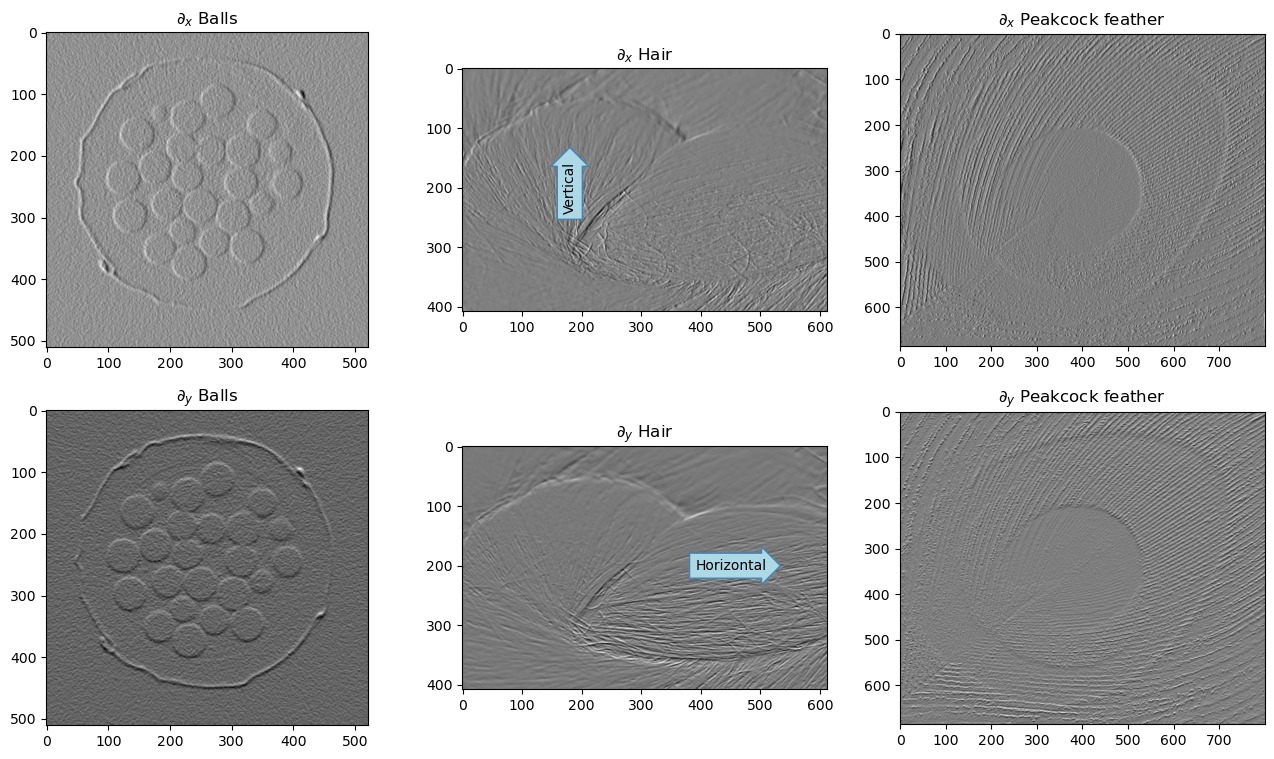

In [136]:
fig,ax = plt.subplots(2,3,figsize=(16,9))
ax=ax.ravel()
sigma=1
ax[0].imshow(gaussian_filter(balls,sigma,order=[0,1]),cmap='gray')
ax[0].set_title(r'$\partial_x$ Balls')
ax[1].imshow(gaussian_filter(hair,sigma,order=[0,1]),cmap='gray')
ax[1].set_title(r'$\partial_x$ Hair')
t = ax[1].text(180,200,  "Vertical",
            ha="center", va="center", rotation=90, size=10,
            bbox=dict(boxstyle="rarrow,pad=0.4",
                      fc="lightblue", ec="steelblue", lw=1))
ax[2].imshow(gaussian_filter(pea,sigma,order=[0,1]),cmap='gray')
ax[2].set_title(r'$\partial_x$ Peakcock feather');

ax[3].imshow(gaussian_filter(balls,sigma,order=[1,0]),cmap='gray')
ax[3].set_title(r'$\partial_y$ Balls')
ax[4].imshow(gaussian_filter(hair,sigma,order=[1,0]),cmap='gray')
ax[4].set_title(r'$\partial_y$ Hair')
t = ax[4].text(450,200,  "Horizontal",
            ha="center", va="center", rotation=0, size=10,
            bbox=dict(boxstyle="rarrow,pad=0.4",
                      fc="lightblue", ec="steelblue", lw=1))
ax[5].imshow(gaussian_filter(pea,sigma,order=[1,0]),cmap='gray')
ax[5].set_title(r'$\partial_y$ Peakcock feather');

In these images, we clearly see that structures in different directions are enhanced. We can for example see that the vertially oriented hairs are enhanced by $\partial_x$ and the horizontally oriented hairs by $\partial_y$ 

### How about the Fourier transform?

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
fballs = np.fft.fftshift(np.fft.fft2(balls));
ax[0].imshow(np.abs(fballs),norm=colors.LogNorm())

fhair = np.fft.fftshift(np.fft.fft2(hair));
ax[1].imshow(np.abs(fhair),norm=colors.LogNorm())

fpea = np.fft.fftshift(np.fft.fft2(pea));
ax[2].imshow(np.abs(fpea),norm=colors.LogNorm());

## The structure tensor

$$J(f) = \nabla{f} \cdot{} \nabla^T f= \left[ \begin{array}{cc}(\partial_x f)^2 & \partial_x f\cdot\partial_y f\\ \partial_y f\cdot\partial_x f & (\partial_y f)^2\end{array}\right]$$

This quite noisy information, therefore it is common to add smoothing in the computation, e.g. using a Gaussian filter.

### Implementing the structure tensor

The equation to implement the structure tensor includes a Gaussian filter, $G_{\sigma}$, with the filter with set by $\sigma$. 

$$J_{\sigma}(f) = G_{\sigma} * \nabla{f} \cdot{} \nabla^T f= \left[\begin{array}{cc}G_{\sigma} * (\partial_x f)^2 & G_{\sigma} * (\partial_x f\cdot\partial_y f)\\ G_{\sigma} * ( \partial_y f\cdot\partial_x f) & G_{\sigma} * (\partial_y f)^2\end{array}\right]$$

In [137]:
def structure_tensor(img,sigma) :
    Ix = gaussian_filter(img,sigma,order=[0,1]) # Technical note: The Gaussian filter function can compute 
    Iy = gaussian_filter(img,sigma,order=[1,0]) # derivatives.
    J = {'J11' : Ix**2,
         'J12' : Ix*Iy,
         'J21' : Ix*Iy,
         'J22' : Iy**2} # A dict of the tensor elements
    
    return J

This function computes the structure tensor of an image and stores it in a dict having the labels J11, J12, J21, and J22. The gradients that normally would be computed using a gradient kernel is here computed together with the Gaussian smoothing of the image. This is a special feature of the Gaussian filter function provided by ```scipy.ndimage```. 

### Looking at the components of the structure tensor

In [138]:
J = structure_tensor(balls,1.5)

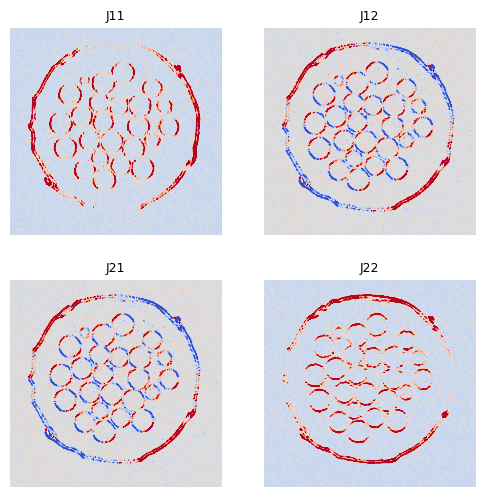

In [139]:
# Visualization
fig,axes =plt.subplots(2,2,figsize=(6,6))
axes=axes.ravel()
for ax,j in zip(axes,J) :
    m = J[j].mean()
    s = J[j].std()
    clims=[m-2*s,m+2*s]
    cmap = 'coolwarm'

    ax.imshow(J[j],clim=clims,cmap=cmap)
    ax.axis('off')
    ax.set_title(j,fontsize=9)

## Local eigen-value analysis of the structure tensor

$$\mathrm{J} \mathrm{v} = \mathrm{\lambda} \mathrm{v}$$

where $\mathrm{\lambda}$ is a diagonal matrix 
$$\mathrm{\lambda} = \left(\begin{array}{cc}\lambda_1 & 0 \\0 &\lambda_2\end{array}\right)$$


### The coherency - C

$$0\leq C = \frac{\lambda_{max}-\lambda_{min}}{\lambda_{max}+\lambda_{min}}=\frac{\sqrt{(J_{22}-J_{11})^2+4J_{12}^2}}{J_{22}+J_{11}}\leq 1$$

Measures the level of confidence of the pixel/region
$$\begin{cases}
C=0 & \lambda_{min}\approx \lambda_{max}\mbox{, the region is homogeneous, i.e. no dominant rotation.} \\
C=1 & \lambda_{min}\ll \lambda_{max}\mbox{, the rotation is well aligned with one of the axes.} \\
0<C<1 & \mbox{the local orientation lies betwenn the axes.} 
\end{cases}$$

In [8]:
def coherency(J,eps=0.1) :
    return np.sqrt(((J['J22']-J['J11'])**2+4*J['J12']**2))/(J['J22']+J['J11']+eps)


The epsilon in the function is a protection against division by zero in the case when $J_{11}$ and $J_{22}$ are close to zero. It should be set to a small value relative to the varaiations in the image.

### Looking at the coherency

In [9]:
C=coherency(J,eps=(J['J22']+J['J11']).std()/10)

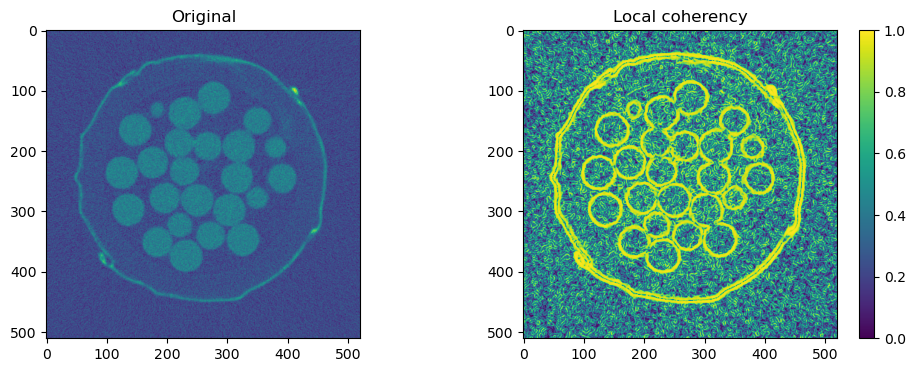

In [10]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(balls)
ax[0].set_title('Original')
a=ax[1].imshow(C,clim=[0,1]) 
plt.colorbar(a,ax=ax[1])
ax[1].set_title('Local coherency');

Here, eps was set to 10% of the standard deviation of  $J_{11}$ and $J_{22}$.

> __Note:__ The coherency is high at the edges.

## Local orientation angle
The eigen vectors represent a rotation matrix. This allows us to compute the local orientation


$$\theta=\frac{1}{2} \arctan{\left(\frac{2 J_{12}}{J_{22}-J_{11}}\right)}$$

In [11]:
def orientation_angle(J,eps=0.1) :
    return 0.5*np.arctan2(2*J["J12"],J["J22"]-J["J11"]+eps)

### Local orientations of the balls

In [12]:
ang = orientation_angle(J,eps=0.01)

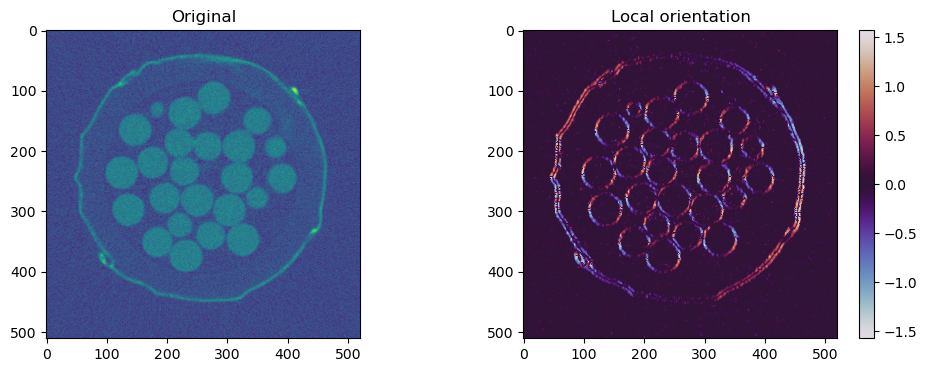

In [13]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(balls)
ax[0].set_title('Original')
a=ax[1].imshow(ang,cmap='twilight',clim=[-np.pi/2,np.pi/2]) 
plt.colorbar(a,ax=ax[1])
ax[1].set_title('Local orientation');

## An image with line structures

In [14]:
Jh = structure_tensor(hair,sigma=0.75)
Ch = coherency(Jh,eps=0.05)
Ah = orientation_angle(Jh,eps=0.1)

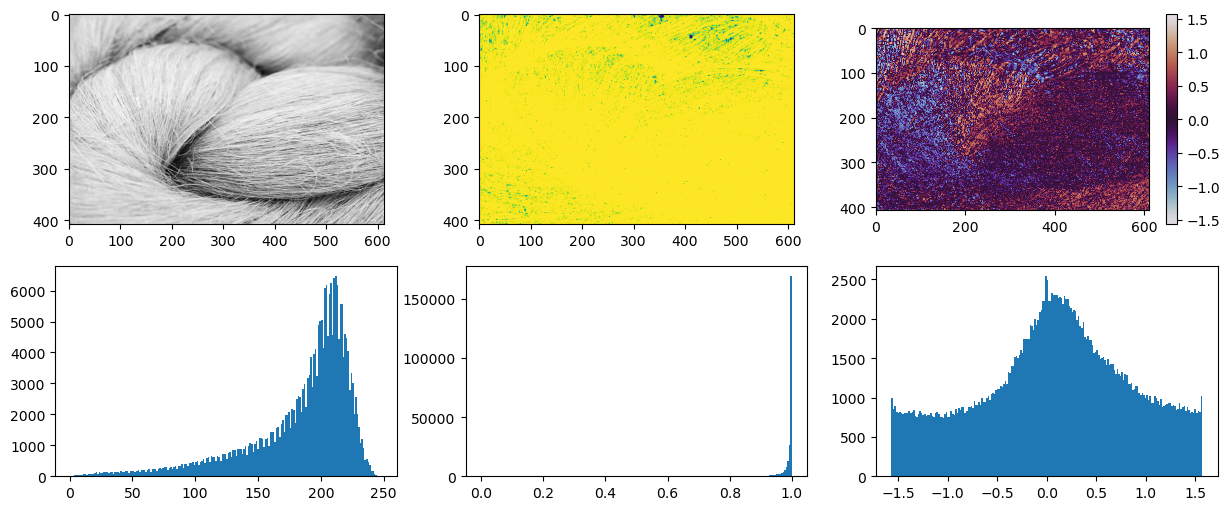

In [15]:
fig,axes = plt.subplots(2,3,figsize=(15,6))
axes = axes.ravel()

axes[0].imshow(hair,cmap='gray')
axes[1].imshow(Ch)
a2=axes[2].imshow(Ah,cmap='twilight',clim=[-np.pi/2,np.pi/2])
fig.colorbar(a2,ax=axes[2])
axes[3].hist(hair.ravel(),bins=200);
axes[4].hist(Ch.ravel(),bins=200);
axes[5].hist(Ah.ravel(),bins=200);

### How is the coherency related to the angle?

In [ ]:
from seaborn import pairplot
import pandas as pd

df = pd.DataFrame({'Coherency': Ch.ravel(), 'Angle': Ah.ravel() })
pairplot(df,plot_kws=dict(alpha=0.002) );

## Compare different images with lines

In [16]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(hair,cmap='gray');
ax[0].set_title('Hair')
ax[1].imshow(pea,cmap='gray');
ax[1].set_title('Peacock feather');

### Structure tensor of the peacock feather

In [17]:
Jp = structure_tensor(pea,sigma=0.75)
Cp = coherency(Jp,eps=1)
Ap = orientation_angle(Jp,eps=0.1)

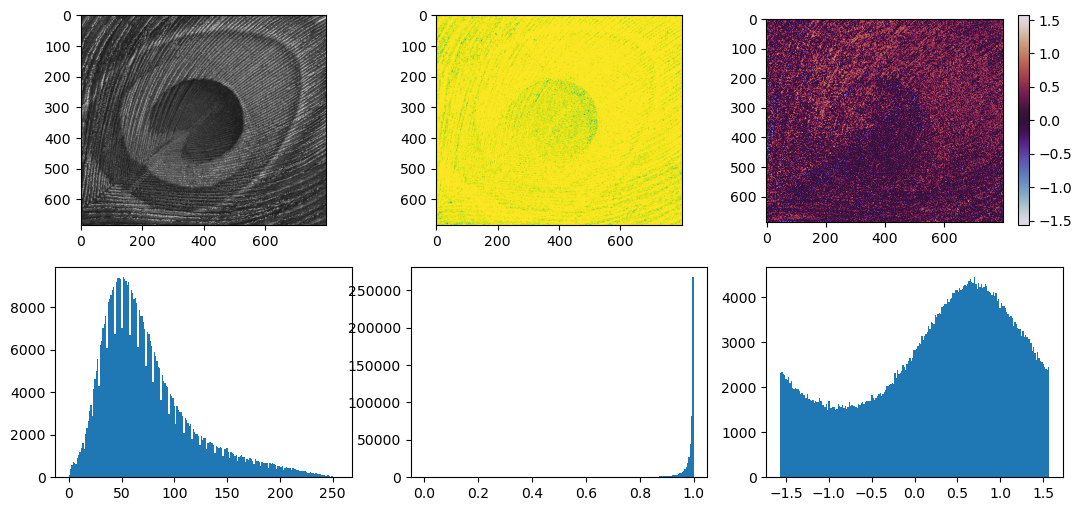

In [18]:
fig,axes = plt.subplots(2,3,figsize=(13,6))
axes = axes.ravel()

axes[0].imshow(pea,cmap='gray')
axes[1].imshow(Cp)
a2=axes[2].imshow(Ap,cmap='twilight',clim=[-np.pi/2,np.pi/2])
fig.colorbar(a2,ax=axes[2])
axes[3].hist(pea.ravel(),bins=200);
axes[4].hist(Cp.ravel(),bins=200);
axes[5].hist(Ap.ravel(),bins=200);

### Compare the orientations

In [19]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax=ax.ravel()
ax[0].imshow(hair,cmap='gray')
t = ax[0].text(300,200,  "Direction",
            ha="center", va="center", rotation=0, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))
ax[1].imshow(pea,cmap='gray');
t = ax[1].text(400,370,  "Direction",
            ha="center", va="center", rotation=40, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))

hh=ax[2].hist(Ah.ravel(),bins=200);
hhm=medfilt(hh[0],9)
ap=hh[1][np.argmax(hhm)]
ax[2].axvline(x=ap, color='r')
ax[2].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[2].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);

hp=ax[3].hist(Ap.ravel(),bins=200);
hpm=medfilt(hp[0],9)
ap=hp[1][np.argmax(hpm)]
ax[3].axvline(x=ap, color='r')
ax[3].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[3].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);


### The orientation locally

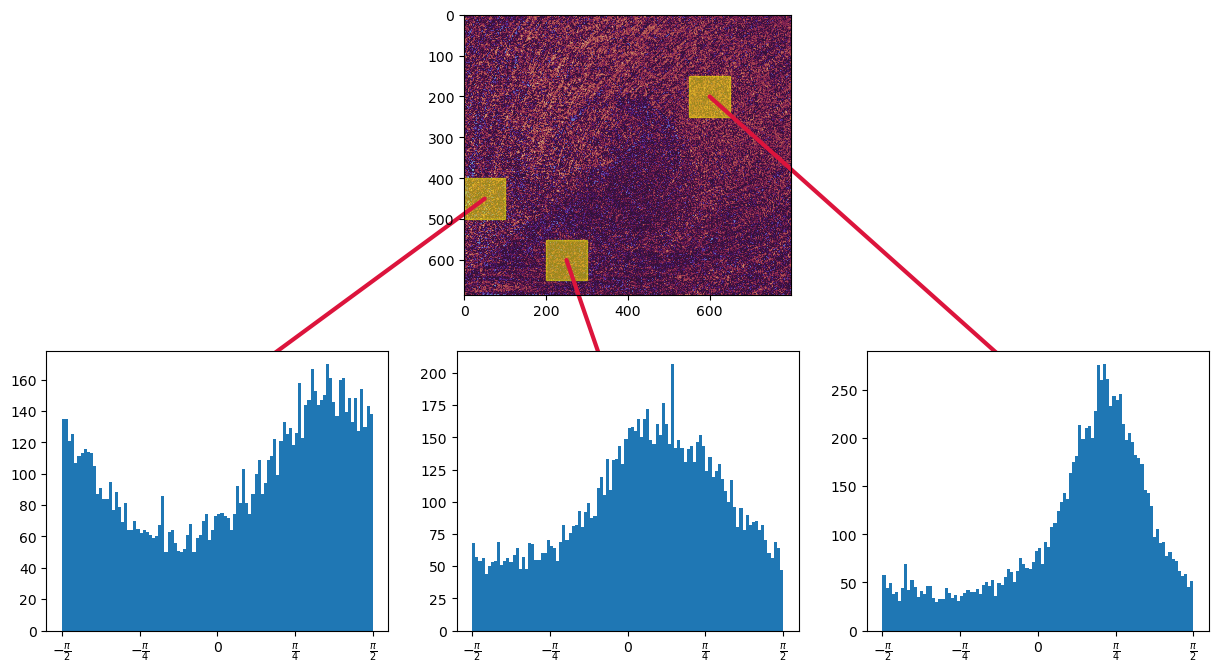

In [128]:
fig,ax = plt.subplots(2,3,figsize=(15,8))
ax=ax.ravel()
ax[0].axis('off')
ax[2].axis('off')
ax[1].imshow(Ap,cmap='twilight')

ax[3].hist(Ap[400:500,0:100].ravel(),bins=100);
ax[3].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[3].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])

ax[4].hist(Ap[550:650,200:300].ravel(),bins=100);
ax[4].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[4].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])

ax[5].hist(Ap[150:250,550:650].ravel(),bins=100);
ax[5].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[5].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'])



rect3 = plt.Rectangle((0,400), 100, 100, facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect3)



rect4 = plt.Rectangle((200,550), 100, 100,
                     facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect4)

rect5 = plt.Rectangle((550,150), 100, 100, facecolor="yellow", alpha=0.5,ec="yellow")
ax[1].add_patch(rect5)



con3 = ConnectionPatch(xyA=(0,150), xyB=(50,450), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[3], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con3)

con4 = ConnectionPatch(xyA=(0,150), xyB=(250,600), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[4], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con4)


con5 = ConnectionPatch(xyA=(0,250), xyB=(600,200), 
                       coordsA="data", coordsB="data", 
                       axesA=ax[5], axesB=ax[1], 
                       color="crimson", lw=3)
ax[1].add_artist(con5);

## Local orientations 

- It is mostly not relevant to observe the orientation per pixel, but rather in a region.
- We saw that there is a uniformly distributed bias in the angles
- The avagerage will be misleading, use max of histogram.

In [141]:
def local_angle(img, w) :
    res=np.zeros([1+img.shape[0]//w,1+img.shape[1]//w])

    for rr,r in enumerate(np.arange(0,img.shape[0],w)) :
        for rc,c in enumerate(np.arange(0,img.shape[1],w)) :
            h,a = np.histogram(img[r:r+w,c:c+w].ravel(),bins=w)
            h=medfilt(h)
            res[rr,rc]= a[np.argmax(h)]
    return res
         

In [143]:
   
# Compute the average angle in a window w
w=100
Ap_avg = local_angle(Ap,w)

# Compute positions
r,c = np.meshgrid(np.arange(0,Ap_avg.shape[0])*w+w/2,np.arange(0,Ap_avg.shape[1]-1)*w+w/2)
# Compute the vectors
u = np.cos(Ap_avg[:,:-1])
v = np.sin(Ap_avg[:,:-1])

NameError: name 'Ap2avg' is not defined

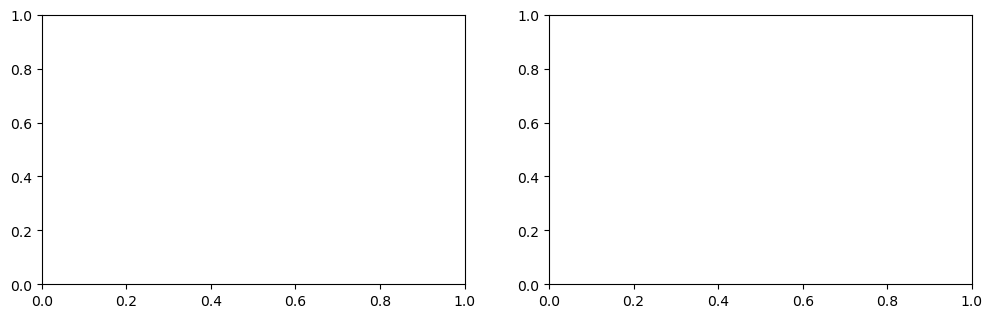

In [131]:
fig,ax = plt.subplots(1,2,figsize=(12,3.5))

a = ax[0].imshow(Ap2avg,clim=[-np.pi/2, np.pi/2],cmap='twilight')
ax[0].set_title('Local orientation angles')
fig.colorbar(a,ax=ax[0])
m,s=pea.mean(), pea.std()
a1=ax[1].imshow(pea,clim=[m-2*s,m+2*s])
fig.colorbar(a1,ax=ax[1])
ax[1].quiver( c,r, u,v, color='red');
ax[1].set_title('Orientations as vector field');


In [132]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def polar_orientation(h,title,cmap='twilight_shifted',subplot_index=111, show_colorbar=True):
    """ Plots an orientation histogram in a polar coordinate system
    Arguments:
    - h
    - title
    - subplot_index
    
    """
    # Generate theta values

    maxidx=np.argmax(h)
    theta = np.linspace(-np.pi/2, np.pi/2, h.shape[0])

    points = np.array([theta, h/h.max()]).T.reshape(-1, 1, 2)

    # Create segments from points
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap,lw=5) # hsv, twilight, twilight_shifted

    lc.set_array(h)
    # Create a polar plot
    ax = plt.subplot(subplot_index, projection='polar')
    ax.add_collection(lc)
    # Set the title
    ax.set_title(title)
    if show_colorbar == True:
        plt.colorbar(lc,ax=ax,shrink=0.8)
    angle=theta[maxidx]*180/np.pi

    t = ax.text(0,0,  "               ",
            ha="center", va="center", rotation=angle, size=10,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))



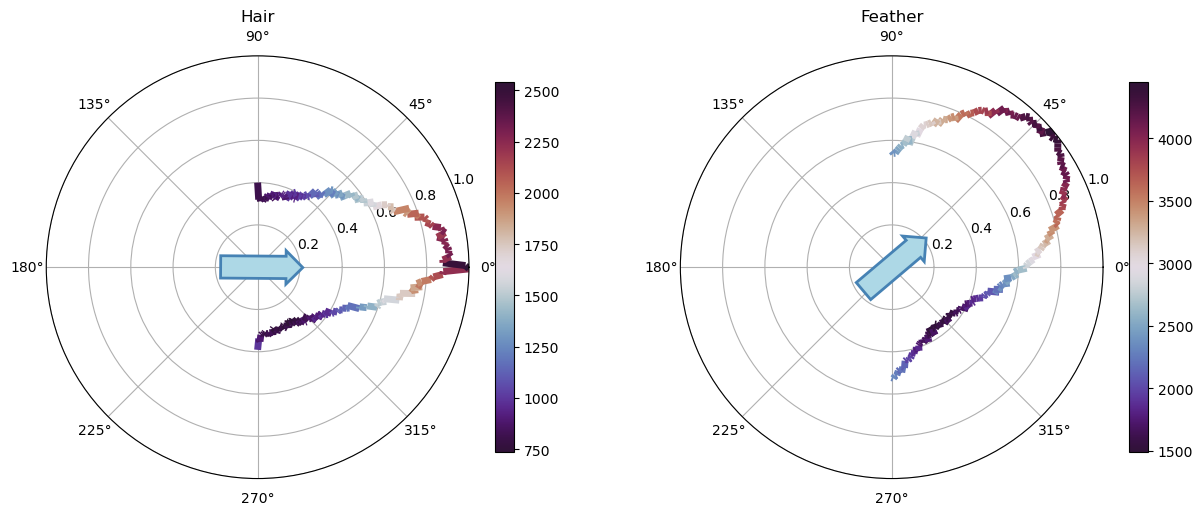

In [123]:
import skimage.filters as flt
plt.figure(figsize=(15,6))
polar_orientation(hh[0], 'Hair',subplot_index=121)
polar_orientation(hp[0], 'Feather',subplot_index=122)

In [ ]:
np.argmax(hp[0])

(0.0, 1.0, 0.0, 1.0)

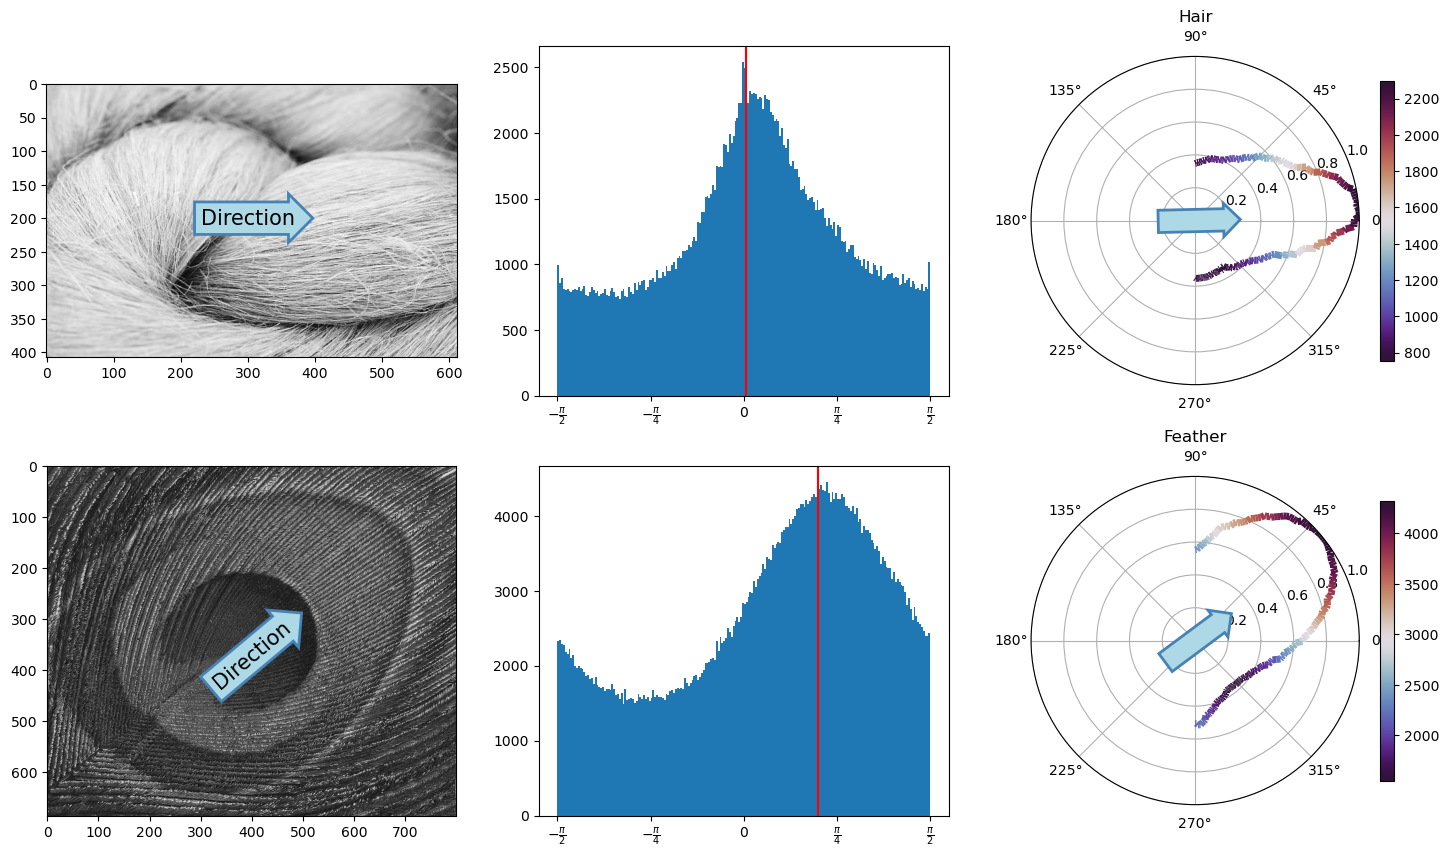

In [165]:
fig,ax = plt.subplots(2,3,figsize=(18,10))
ax=ax.ravel()
ax[0].imshow(hair,cmap='gray')
t = ax[0].text(300,200,  "Direction",
            ha="center", va="center", rotation=0, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))

hh=ax[1].hist(Ah.ravel(),bins=200);
hhm=medfilt(hh[0],9)
ap=hh[1][np.argmax(hhm)]
ax[1].axvline(x=ap, color='r')
ax[1].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[1].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);

ax[2].axis('off')
polar_orientation(hhm, 'Hair',subplot_index=233)


ax[3].imshow(pea,cmap='gray');
t = ax[3].text(400,370,  "Direction",
            ha="center", va="center", rotation=40, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3",
                      fc="lightblue", ec="steelblue", lw=2))

hp=ax[4].hist(Ap.ravel(),bins=200);
hpm=medfilt(hp[0],9)
ap=hp[1][np.argmax(hpm)]
ax[4].axvline(x=ap, color='r')
ax[4].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[4].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);

polar_orientation(hpm, 'Feather',subplot_index=236)
ax[5].axis('off')

## Testing the deer fur

In [194]:
fur = io.imread('figures/deer-fur.jpg').astype(float).mean(axis=2)

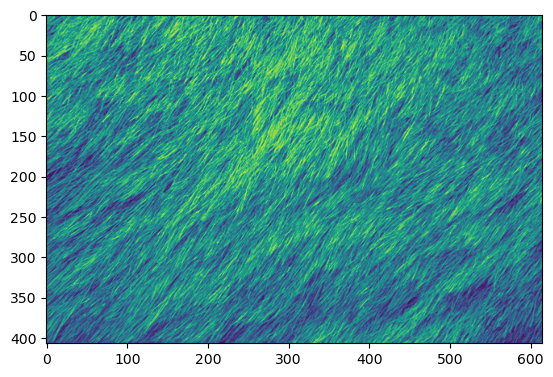

In [195]:
plt.imshow(fur)

In [187]:
ffur = np.fft.fftshift(np.fft.fft2(fur-fur.mean()))

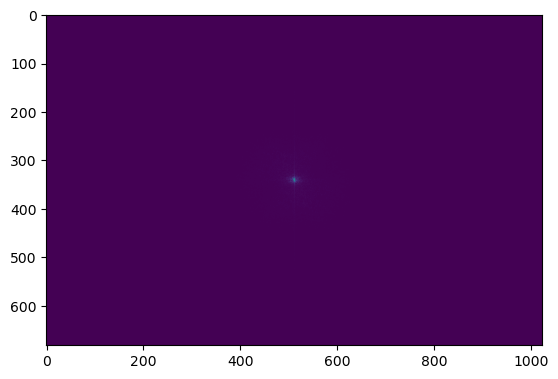

In [188]:
plt.imshow(np.abs(ffur))

In [196]:
Jf = structure_tensor(fur[::-1],sigma=2)
Cf = coherency(Jf,eps=1)
Af = orientation_angle(Jf,eps=0.1)

In [197]:
plt.imshow(Af)

In [198]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
hfur=ax[1].hist(Af.ravel(),bins=200);
ax[0].imshow(fur,cmap='gray')
ax[1].set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[1].set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']);
ax[2].axis('off')
polar_orientation(hfur[0], 'Fur',subplot_index=133)